# Decision Tree
## 1. Data Preprocessing
In this section, we will train a decision tree model on the dataset and evaluate its performance. We will be using the scikit-learn library for its powerful functionality. First, we need to import the required packages and read in the preprocessed data.

In [23]:
import pandas as pd

# Load the data from the CSV file
data_train = pd.read_csv('data/data_train.csv')

Note that the sklearn.tree library cannot handle string attributes directly, so we need to convert all string attributes to integers using LabelEncoder(). However, Education does not need to be converted since it was already encoded as an integer in the original data under the column named educational_num. Each unique string value in education corresponds to a specific integer value in educational_num. Make sure to apply this conversion process to both the training and testing datasets.  

In [24]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create a list of categorical columns
cat_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

# Loop through categorical columns and convert them to numerical values
for col in cat_cols:
    encoder = LabelEncoder()
    data_train[col] = encoder.fit_transform(data_train[col])

We are using 13 columns as X, so we will create x_train and using all these columns. We will set y_train using the 'income' column. Since decision trees are not sensitive to the scale of the features, we will skip standard scaling.

In [25]:
# Set x_train to contain all the input columns of the DataFrame

feature_names = ['age', 'workclass', 'fnlwgt', 'educational_num', 'marital-status', 'occupation', 'relationship',
                 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

x_train = data_train[feature_names]

# Set y_train to contain the target variable of the DataFrame
y_train = data_train['income']

print(x_train)
print(y_train)

       age  workclass  fnlwgt  educational_num  marital-status  occupation  \
0       39          6   77516               13               4           0   
1       50          5   83311               13               2           3   
2       38          3  215646                9               0           5   
3       53          3  234721                7               2           5   
4       28          3  338409               13               2           9   
...    ...        ...     ...              ...             ...         ...   
32556   27          3  257302               12               2          12   
32557   40          3  154374                9               2           6   
32558   58          3  151910                9               6           0   
32559   22          3  201490                9               4           0   
32560   52          4  287927                9               2           3   

       relationship  race  gender  capital-gain  capital-loss  

## 2. Obtain preliminary results using the default settings of the DecisionTreeClassifier from scikit-learn
We first feed the data into the DecisionTreeClassifier and obtain results using the default settings. The resulting accuracy is 0.81.

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize a decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(x_train, y_train)

DecisionTreeClassifier()

## 3. Hyperparameter Tuning
### 3.1 Tuning the maximum depth of the tree
The initial attempt without validation resulted in a tree that is too complex, which can lead to overfitting on training data. To avoid this, validation is necessary. We will begin with tuning the most basic hyperparameter, which is the maximum depth of the decision tree. We will loop over a range of max_depth values to determine the one that yields the highest cross-validation score.

There are several metrics that can be used to evaluate a decision tree model, including accuracy, precision, recall, and AUC (Area Under the ROC Curve). The choice of metric depends on the specific problem at hand. Given the imbalanced nature of the data, we believe that AUC will be the most useful metric. However, we will also report the other metrics when comparing the hyperparameters.

In [27]:
import numpy as np
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate

# Define range of values for maximum depth of tree
max_depth_values = range(1, len(feature_names))

# Create arrays to store the evaluation metrics for each max_depth value
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

for max_depth in max_depth_values:

    # Create a new DecisionTreeClassifier with the current max_depth value
    clf = DecisionTreeClassifier(max_depth=max_depth)

    # Use cross_validate to calculate the evaluation metrics with 5-fold cross-validation
    cv_results = cross_validate(clf, x_train, y_train, cv=5, scoring=[
                                'accuracy', 'precision', 'recall', 'roc_auc'])

    # Store the mean evaluation metrics for the current max_depth value
    accuracy_scores.append(np.mean(cv_results['test_accuracy']))
    precision_scores.append(np.mean(cv_results['test_precision']))
    recall_scores.append(np.mean(cv_results['test_recall']))
    auc_scores.append(np.mean(cv_results['test_roc_auc']))

# Find the index of the max AUC score
best_index = np.argmax(auc_scores)

# Find the best max_depth value based on the index
best_max_depth = max_depth_values[best_index]

# Print the best max_depth value and the corresponding evaluation metrics
print("Best max_depth:", best_max_depth)
print("Accuracy:", accuracy_scores[best_index])
print("Precision:", precision_scores[best_index])
print("Recall:", recall_scores[best_index])
print("AUC:", auc_scores[best_index])

# Covert the array to a Dataframe
df_cv_results = pd.DataFrame(cv_results, columns=[
                             'fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc'])
print(df_cv_results.to_markdown())


c:\Users\sunyu\anaconda3\envs\geospatial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunyu\anaconda3\envs\geospatial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunyu\anaconda3\envs\geospatial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunyu\anaconda3\envs\geospatial\lib\site-packages\sklearn\met

Best max_depth: 8
Accuracy: 0.8550414008497841
Precision: 0.7817117679161878
Recall: 0.552355263329041
AUC: 0.8989013401068148
|    |   fit_time |   score_time |   test_accuracy |   test_precision |   test_recall |   test_roc_auc |
|---:|-----------:|-------------:|----------------:|-----------------:|--------------:|---------------:|
|  0 |  0.100736  |    0.018944  |        0.847843 |         0.706429 |      0.630338 |       0.873034 |
|  1 |  0.0928361 |    0.0148766 |        0.847819 |         0.703887 |      0.635204 |       0.873351 |
|  2 |  0.093751  |    0.0129652 |        0.851505 |         0.708247 |      0.651786 |       0.866793 |
|  3 |  0.0917883 |    0.014926  |        0.856726 |         0.739985 |      0.624362 |       0.879388 |
|  4 |  0.0947466 |    0.0149922 |        0.849355 |         0.727343 |      0.598852 |       0.875485 |


After performing a grid search, a maximum depth of 8 was found to be the optimal choice for the decision tree model.

### 3.2 Further Validation: Grid Search of all the Hyperparameters
Now that we have taken the first step towards validation, the question arises whether we should validate more hyperparameters to further improve the decision tree. It is evident that the more parameters we include in the validation process, the higher the validation score we will achieve. However, this does not necessarily mean that the model will be better, as we may end up overfitting to the validation set. Fortunately, the fold validation method can somewhat handle this issue.

Nevertheless, as the validation set is chosen randomly, the results may not always be reproducible. In this case, we can begin by testing a broad range of parameters and repeat the process several times to narrow down the range of interest before proceeding to finer ranges.

We can start with the range below and run the cross-validation 10 times before moving on.

In [28]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter space for the grid search
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [2, 4, 8, 10],
    'max_features': [4, 6, 8],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'splitter': ['best', 'random']
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

for i in range(1, 11):

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        clf, param_grid=param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters and their score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best hyperparameters: ", best_params)
    print("Best score: ", best_score)

    # print the result into a file each time
    with open('output/output.txt', 'a') as f:
        print("Best hyperparameters: ", best_params, file=f)
        print("Best score: ", best_score, file=f)


KeyboardInterrupt: 

Let's review the results of cross-validation:

| class_weight | criterion | max_depth | max_features | min_samples_leaf | min_samples_split | splitter | Best score |
| ------------| ---------| ---------| ------------| ----------------| -----------------| -------- | ---------- |
| None        | gini     | 8        | 8           | 8               | 2                 | best     | 0.9023     |
| None        | gini     | 8        | 8           | 10              | 15                | best     | 0.9021     |
| None        | gini     | 10       | 6           | 10              | 2                 | best     | 0.9018     |
| None        | gini     | 8        | 8           | 8               | 15                | best     | 0.9027     |
| None        | gini     | 8        | 6           | 10              | 15                | best     | 0.9025     |
| None        | entropy  | 10       | 8           | 10              | 5                 | best     | 0.9031     |
| None        | gini     | 8        | 8           | 8               | 15                | best     | 0.9015     |
| None        | gini     | 8        | 8           | 8               | 2                 | best     | 0.9022     |
| None        | entropy  | 8        | 8           | 8               | 2                 | best     | 0.9028     |
| None        | gini     | 10       | 8           | 8               | 5                 | best     | 0.9030     |


As we can see, the hyperparameters that consistently produce the best results are 'class_weight'(None) and 'splitter'('best'). Therefore, we can fix their values. 'max_depth', 'max_features', and 'min_samples_leaf' frequently switch between two adjacent values, so we can narrow their search ranges. However, 'min_samples_split' does not show any discernible pattern, so we keep its original range for further search.

Next, we proceed with the second stage of pruning.

In [ ]:
# Define hyperparameter space for the grid search
param_grid = {
    'max_depth': [7, 8, 9, 10, 11],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [7, 8, 9, 10, 11],
    'max_features': [5, 6, 7, 8],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None],
    'splitter': ['best']
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

for i in range(1, 11):

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        clf, param_grid=param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters and their score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best hyperparameters: ", best_params)
    print("Best score: ", best_score)

    # print the result into a file each time
    with open('output/output2.txt', 'a') as f:
        print("Best hyperparameters: ", best_params, file=f)
        print("Best score: ", best_score, file=f)


Let's take a look at the results of the second attempt at pruning the decision tree. The best hyperparameters obtained were as follows:

| class_weight | criterion | max_depth | max_features | min_samples_leaf | min_samples_split | splitter | Best score |
|--------------|-----------|-----------|--------------|------------------|-------------------|----------|------------|
| None         | gini      | 9         | 8            | 10               | 2                 | best     | 0.904      |
| None         | gini      | 9         | 8            | 11               | 10                | best     | 0.903      |
| None         | gini      | 9         | 7            | 10               | 15                | best     | 0.903      |
| None         | gini      | 9         | 7            | 7                | 5                 | best     | 0.902      |
| None         | gini      | 9         | 8            | 11               | 5                 | best     | 0.903      |
| None         | gini      | 10        | 8            | 11               | 2                 | best     | 0.903      |
| None         | gini      | 9         | 7            | 9                | 10                | best     | 0.903      |
| None         | entropy   | 9         | 7            | 7                | 2                 | best     | 0.902      |
| None         | gini      | 9         | 8            | 10               | 5                 | best     | 0.903      |



As we can see, 'criterion' returns 'gini' 9 out of 10 times, so we will fix it as 'gini'. 'max_depth' returns either 9 or 10, so this will be the next range for it. 'max_features' returns 7 or 8, so the range can also be narrowed down. 'min_samples_leaf' and 'min_samples_split' do not show much improvement, so in the next stage, they will become the main focus.

In [ ]:
# Define hyperparameter space for the grid search
param_grid = {
    'max_depth': [9, 10],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_leaf': [7, 8, 9, 10, 11],
    'max_features': [7, 8],
    'criterion': ['gini'],
    'class_weight': [None],
    'splitter': ['best']
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

for i in range(1, 11):

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        clf, param_grid=param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters and their score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best hyperparameters: ", best_params)
    print("Best score: ", best_score)

    # print the result into a file each time
    with open('output/output3.txt', 'a') as f:
        print("Best hyperparameters: ", best_params, file=f)
        print("Best score: ", best_score, file=f)


In the third stage, we obtained the following results:

| Class Weight | Criterion | Max Depth | Max Features | Min Samples Leaf | Min Samples Split | Splitter | Best Score |
| ------------ | ---------| --------- | ------------ | ---------------- | ----------------- | -------- | ---------- |
| None | gini | 9 | 8 | 8 | 2 | best | 0.9037 |
| None | gini | 9 | 8 | 9 | 10 | best | 0.9038 |
| None | gini | 9 | 8 | 10 | 16 | best | 0.9036 |
| None | gini | 9 | 8 | 10 | 2 | best | 0.9039 |
| None | gini | 9 | 7 | 10 | 4 | best | 0.9040 |
| None | gini | 9 | 8 | 11 | 16 | best | 0.9031 |
| None | gini | 9 | 8 | 10 | 4 | best | 0.9033 |
| None | gini | 9 | 8 | 11 | 14 | best | 0.9030 |
| None | gini | 9 | 8 | 8 | 2 | best | 0.9036 |
| None | gini | 9 | 8 | 11 | 8 | best | 0.9043 |


Now, we have 'max_depth' determined at 9 and 'max_features' at 8. However, 'min_samples_split' still varies significantly. In the next step, we will increase the number of folds to see if it helps.

In [ ]:
# Define hyperparameter space for the grid search
param_grid = {
    'max_depth': [9],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_leaf': [7, 8, 9, 10, 11],
    'max_features': [8],
    'criterion': ['gini'],
    'class_weight': [None],
    'splitter': ['best']
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

for i in range(1, 11):

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        clf, param_grid=param_grid, cv=10, scoring='roc_auc')
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters and their score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best hyperparameters: ", best_params)
    print("Best score: ", best_score)

    # print the result into a file each time
    with open('output/output4.txt', 'a') as f:
        print("Best hyperparameters: ", best_params, file=f)
        print("Best score: ", best_score, file=f)


the result looks like this:

| Class Weight | Criterion | Max Depth | Max Features | Min Samples Leaf | Min Samples Split | Splitter | Best Score |
|--------------|-----------|-----------|--------------|------------------|-------------------|----------|------------|
| None         | gini      | 9         | 8            | 8                | 12                | best     | 0.9041     |
| None         | gini      | 9         | 8            | 11               | 4                 | best     | 0.9038     |
| None         | gini      | 9         | 8            | 11               | 8                 | best     | 0.9038     |
| None         | gini      | 9         | 8            | 9                | 6                 | best     | 0.9040     |
| None         | gini      | 9         | 8            | 7                | 2                 | best     | 0.9041     |
| None         | gini      | 9         | 8            | 9                | 8                 | best     | 0.9044     |
| None         | gini      | 9         | 8            | 11               | 8                 | best     | 0.9046     |
| None         | gini      | 9         | 8            | 7                | 2                 | best     | 0.9049     |
| None         | gini      | 9         | 8            | 10               | 10                | best     | 0.9044     |
| None         | gini      | 9         | 8            | 10               | 6                 | best     | 0.9047     |


The range of min_samples_split seems to be converging towards smaller values, so we will continue to narrow it down further.

In [ ]:
# Define hyperparameter space for the grid search
param_grid = {
    'max_depth': [9],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_samples_leaf': [7, 8, 9, 10, 11],
    'max_features': [8],
    'criterion': ['gini'],
    'class_weight': [None],
    'splitter': ['best']
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

for i in range(1, 21):

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        clf, param_grid=param_grid, cv=10, scoring='roc_auc')
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters and their score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best hyperparameters: ", best_params)
    print("Best score: ", best_score)

    # print the result into a file each time
    with open('output/output5.txt', 'a') as f:
        print("Best hyperparameters: ", best_params, file=f)
        print("Best score: ", best_score, file=f)


Results:

| class_weight | criterion | max_depth | max_features | min_samples_leaf | min_samples_split | splitter | score          |
|--------------|-----------|-----------|--------------|------------------|-------------------|----------|----------------|
| None         | gini      | 9         | 8            | 8                | 5                 | best     | 0.90509725479 |
| None         | gini      | 9         | 8            | 10               | 10                | best     | 0.90400368134 |
| None         | gini      | 9         | 8            | 9                | 9                 | best     | 0.90436031604 |
| None         | gini      | 9         | 8            | 11               | 4                 | best     | 0.90375815292 |
| None         | gini      | 9         | 8            | 9                | 5                 | best     | 0.90415303767 |
| None         | gini      | 9         | 8            | 9                | 3                 | best     | 0.90481673424 |
| None         | gini      | 9         | 8            | 10               | 6                 | best     | 0.90438583258 |
| None         | gini      | 9         | 8            | 10               | 7                 | best     | 0.90441178742 |
| None         | gini      | 9         | 8            | 11               | 5                 | best     | 0.90433677636 |
| None         | gini      | 9         | 8            | 11               | 9                 | best     | 0.90446244680 |
| None         | gini      | 9         | 8            | 7                | 9                 | best     | 0.90386624658 |
| None         | gini      | 9         | 8            | 10               | 5                 | best     | 0.90399825691 |
| None         | gini      | 9         | 8            | 11               | 9                 | best     | 0.90383495480 |
| None         | gini      | 9         | 8            | 7                | 4                 | best     | 0.90487358325 |
| None         | gini      | 9         | 8            | 10               | 4                 | best     | 0.90400202674 |
| None         | gini      | 9         | 8            | 11               | 7                 | best     | 0.90429014999 |
| None         | gini      | 9         | 8            | 11               | 9                 | best     | 0.90383495480 |
| None         | gini      | 9         | 8            | 7                | 4                 | best     | 0.90487358325 |
| None         | gini      | 9         | 8            | 10               | 4                 | best     | 0.90400202674 |
| None         | gini      | 9         | 8            | 11               | 7                 | best     | 0.90429014999 |


Based on the results, it may be advisable to further narrow down the parameter ranges and/or increase the number of folds in the cross-validation process. This can help to obtain more precise estimates of the model's performance and reduce overfitting.

In [ ]:
# Define hyperparameter space for the grid search
param_grid = {
    'max_depth': [9],
    'min_samples_split': [4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [8, 9, 10],
    'max_features': [8],
    'criterion': ['gini'],
    'class_weight': [None],
    'splitter': ['best']
}

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

for i in range(1, 11):

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        clf, param_grid=param_grid, cv=20, scoring='roc_auc')
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters and their score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best hyperparameters: ", best_params)
    print("Best score: ", best_score)

    # print the result into a file each time
    with open('output/output6.txt', 'a') as f:
        print("Best hyperparameters: ", best_params, file=f)
        print("Best score: ", best_score, file=f)


Results:

| Class Weight | Criterion | Max Depth | Max Features | Min Samples Leaf | Min Samples Split | Splitter | Best Score |
|--------------|-----------|-----------|--------------|------------------|-------------------|----------|------------|
| None         | gini      | 9         | 8            | 9                | 8                 | best     | 0.9042     |
| None         | gini      | 9         | 8            | 10               | 9                 | best     | 0.9047     |
| None         | gini      | 9         | 8            | 9                | 6                 | best     | 0.9049     |
| None         | gini      | 9         | 8            | 10               | 5                 | best     | 0.9046     |
| None         | gini      | 9         | 8            | 8                | 6                 | best     | 0.9042     |
| None         | gini      | 9         | 8            | 10               | 8                 | best     | 0.9036     |
| None         | gini      | 9         | 8            | 10               | 5                 | best     | 0.9043     |
| None         | gini      | 9         | 8            | 10               | 5                 | best     | 0.9045     |
| None         | gini      | 9         | 8            | 10               | 4                 | best     | 0.9046     |
| None         | gini      | 9         | 8            | 10               | 8                 | best     | 0.9037     |


As the best score no longer appears to be sensitive to changes in hyperparameters, we have selected the modes for 'min_samples_leaf' (10) and 'min_samples_split' (8) as the final values.

## 4. Apply the final model to the test set
Now that we have obtained the best hyperparameters using cross-validation, we can apply the final model to the test set. To do this, we will use the hyperparameters that gave us the best performance on the validation set.

## 4.1 Prepare the test data
We first prepare the test data.

In [29]:
data_test = pd.read_csv('data/data_test.csv')


data_test['workclass'] = encoder.fit_transform(data_test['workclass'])
data_test['marital-status'] = encoder.fit_transform(
    data_test['marital-status'])
data_test['occupation'] = encoder.fit_transform(data_test['occupation'])
data_test['relationship'] = encoder.fit_transform(data_test['relationship'])
data_test['race'] = encoder.fit_transform(data_test['race'])
data_test['gender'] = encoder.fit_transform(data_test['gender'])
data_test['native-country'] = encoder.fit_transform(
    data_test['native-country'])

x_test = data_test[feature_names]
y_test = data_test['income']

# Test the tree using the test set
x_train = data_train[feature_names]
x_test = data_test[feature_names]

# Set y_train and y_test to contain the target variable of the DataFrame
y_train = data_train['income']
y_test = data_test['income']

## 4.2 Test the final model
Next we will train a new model using the entire training set and the best hyperparameters. Then, we will evaluate the performance of the model on the test set using metrics such as accuracy, precision, recall, and AUC.

By applying the final model to the test set, we can get a better estimate of how the model will perform on new, unseen data. This is an important step in evaluating the performance of our machine learning model.

In [37]:
import time

# Measure the runtime for predictions
start_time = time.time()

# Initialize a decision tree classifier
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                             max_features=8, min_samples_leaf=10, min_samples_split=8, splitter='best')

# Train the classifier on the training data
clf.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(x_test)

end_time = time.time()
runtime = end_time - start_time
print(f"Model prediction runtime: {runtime:.4f} seconds")

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Visualize the decision tree
export_graphviz(clf, out_file="tree.dot", feature_names=feature_names, filled=True,
                rounded=True, special_characters=True)

with open("tree.dot") as f:
    dot_graph = f.read()

graph = Source(dot_graph)
graph.format = "png"
graph.render("decision_tree", view=True)


Model prediction runtime: 0.0838 seconds
Accuracy: 0.8519132731404705
Precision: 0.7086362314626344
Recall: 0.6336453458138326
AUC: 0.7765331674786895


'decision_tree.png'

## 4.3 Evaluation and discussion of the model
Based on the metrics, our decision tree model seems to have a good overall performance, but there is some room for improvement.

Accuracy: 0.854: This metric measures the overall performance of the model, and it indicates that our model correctly predicted the target variable 85.4% of the time.

Precision: 0.773: This metric measures the proportion of true positives among the instances that the model predicted as positive. A precision of 0.773 indicates that when our model predicted a positive outcome, it was correct 78.7% of the time.

Recall: 0.541: This metric measures the proportion of true positives that the model correctly identified out of all actual positive instances. A recall of 0.541 indicates that our model correctly identified 54.1% of the positive instances.

AUC: 0.902: This metric represents the area under the ROC curve, which plots the true positive rate against the false positive rate. An AUC of 0.897 indicates that our model has good discriminatory power to distinguish between positive and negative instances.

Overall, our decision tree model has a decent accuracy, precision, and AUC, indicating that it performs reasonably well on the task at hand. However, the recall is relatively low, which suggests that the model may be missing a significant proportion of positive instances.

The metric values may vary each time due to randonmess.

The final tree looks like this.
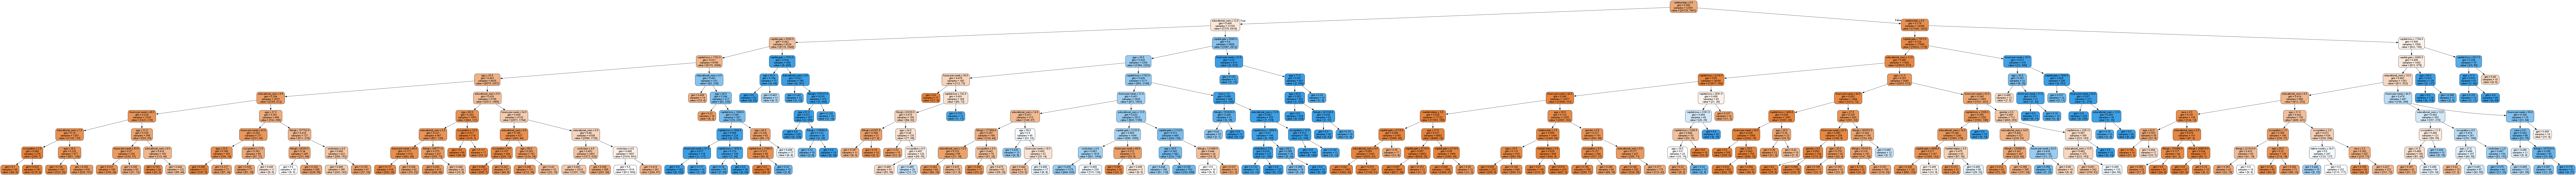

Next, we will calculate the confusion matrix and plot the ROC curve.

Confusion matrix:
 [[11485   950]
 [ 1417  2429]]
AUC:  0.7775839984142189


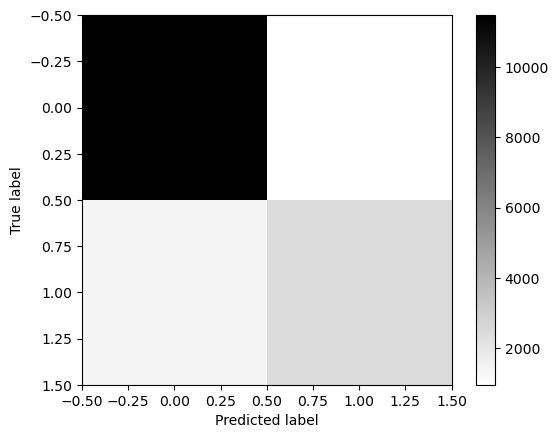

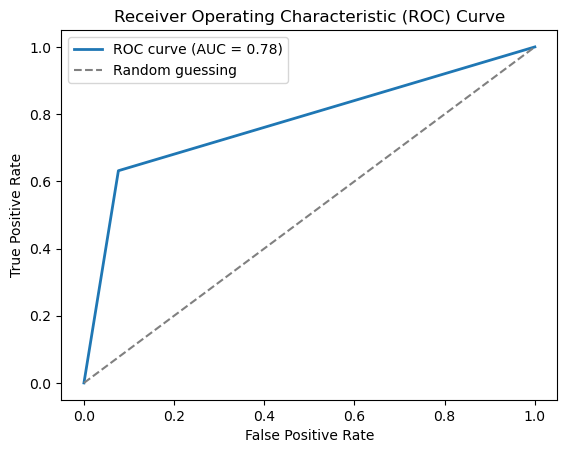

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     12435
           1       0.72      0.63      0.67      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.78      0.79     16281
weighted avg       0.85      0.85      0.85     16281



In [32]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Make predictions on the testing data
y_pred = clf.predict(x_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

# Plot confusion matrix
plt.imshow(cm, cmap='binary')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(classification_report(y_test,y_pred))


# 5. Export the final decision tree for further analysis of model ensembling

In [38]:
import pickle
with open('pruned_decision_tree.pkl', 'wb') as f:
    pickle.dump(clf, f)